<a href="https://colab.research.google.com/github/PietroSchgor/Bayesian-Project/blob/main/Model2_GP1912Matern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ProjectBayesianDirectory

Mounted at /gdrive
/gdrive/My Drive/ProjectBayesianDirectory


In [2]:
# Install cmdstanpy module
!pip install cmdstanpy

!pip list | grep cmdstanpy


cmdstanpy                          1.2.5


In [3]:
# Install arviz module (With version 2.33.1 you will need a special version of arviz)
!pip install arviz
!pip list | grep arviz

arviz                              0.20.0


In [4]:
# Install cmdstan -- Just for the first time!
from cmdstanpy import install_cmdstan
install_cmdstan()

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /tmp/tmpkawyf5_t
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.36.0
Test model compilation


True

In [5]:
from cmdstanpy import cmdstan_path
cmdstan_path()

'/root/.cmdstan/cmdstan-2.36.0'

In [6]:
# Create folder to store .stan files
import os
if not os.path.exists("./stan"):
    os.mkdir("./stan")

# Import modules
import numpy as np
import arviz as az
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Upload data




In [7]:
y = pd.read_csv('TremorProb_1.csv')
print(y.head())

   -0.620922462937449  -0.668689165888089  -0.409872821087173  \
0           -0.620922           -0.668689           -0.409873   
1           -0.620922           -0.668689           -0.409873   
2           -0.620922           -0.668689           -0.409873   
3           -0.620922           -0.668689           -0.409873   
4           -0.620922           -0.668689           -0.409873   

   -0.46836544467914  -0.672098617117627  -0.568842619576277  \
0          -0.468365           -0.672099           -0.568843   
1          -0.468365           -0.672099           -0.568843   
2          -0.468365           -0.672099           -0.568843   
3          -0.468365           -0.672099           -0.568843   
4          -0.468365           -0.672099           -0.568843   

   -0.478079682575386  -0.417804016451204  -0.758451513461839  \
0            -0.47808           -0.417804           -0.758452   
1            -0.47808           -0.417804           -0.758452   
2            -0.47808        

In [8]:
N = y.shape[0]
d = y.shape[1]
print("Dimension is", N)
print("Sample is", d)

Dimension is 287
Sample is 15


In [9]:
x = np.linspace(0,1,N)

In [10]:
y = np.array(np.transpose(y))

In [11]:
y

array([[-0.62092246, -0.62092246, -0.62092246, ..., -0.62092246,
        -0.62092246, -0.62092246],
       [-0.66868917, -0.66868917, -0.66868917, ...,  0.59905107,
         0.25255206,  0.12731979],
       [-0.40987282, -0.40987282, -0.40987282, ..., -0.31308653,
        -0.35717438, -0.40126223],
       ...,
       [-0.4982822 , -0.4982822 , -0.4982822 , ..., -0.4982822 ,
        -0.4982822 , -0.4982822 ],
       [-0.6061394 , -0.6061394 , -0.6061394 , ..., -0.3327095 ,
        -0.43775713, -0.59682581],
       [-0.42226794, -0.42226794, -0.42226794, ..., -0.42226794,
        -0.42226794, -0.42226794]])

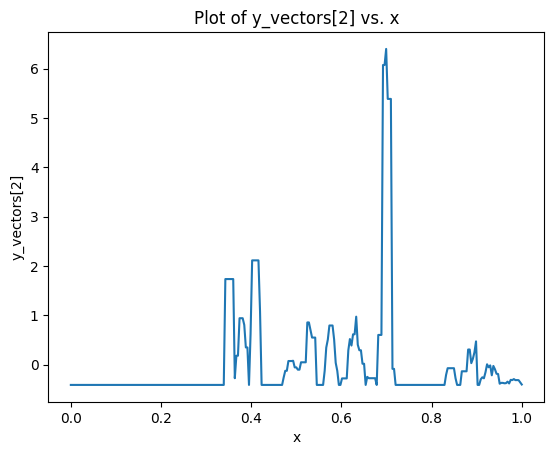

In [13]:
plt.plot(x, y[2,:])
plt.xlabel("x")
plt.ylabel("y_vectors[2]")
plt.title("Plot of y_vectors[2] vs. x")
plt.show()

# Current Model
This is the model we are going to use
$$
  y_t(s) = (1-\beta) \mu(s) + \beta y_{t-1}(s) + ϵ
$$

\\
Let $\mathbf{y}_{t}(s) = (Y(\mathbf{s}, t), \dots, Y(\mathbf{s}, t)) \in \mathbb{R}^{N}$. The hierarchical bayesian model is as follows

\\

\begin{aligned}
    \mathbf{y_t} \mid \beta, \mathbf{\mu}, \boldsymbol{\tau^2}, \mathbf{y_{t-1}} &\sim \text{multivariate normal}((1-\beta) \mu + \beta \mathbf{y}_{t-1}, diag(\tau^2))\\
    \mu &\sim \text{multivariate normal}(0,\sigma_{\alpha}^2 \mathbf{A}(\rho))\\
    %\rho &\sim \text{InvGamma}(5, 5) \\
    \sigma_\alpha &\sim \text{InvGamma}(1, 2) \\
    %\alpha &\sim \text{normal}(0, 1) \\
    \tau &\sim \text{InvGamma}(1, 2) \\
    \beta &\sim \text{Beta}(1.5,1.5)
\end{aligned}

And $$K\left(x \mid \alpha, \rho, \sigma \right)_{i,j} = \alpha^2 \exp \left( -\frac{1}{2\rho^2} \sum_{d=1}^{D} \left(x_{i,d} - x_{j,d}\right)^2 \right) + \delta_{i,j} \sigma^2$$

In [16]:
# Useful functions for the spatio-temporal model
spt_tools = \
"""
// Computes Temporal covariance kernel using Matern 3/2
matrix cov_time_matern(int T, real ell) {
    matrix[T, T] cov;
    real sqrt_3 = sqrt(3.0);

    for (i in 1:T) {
        cov[i, i] = 1; // Diagonale principale: varianza unitaria
        for (j in (i+1):T) {
            real d = abs(i - j); // Distanza temporale
            cov[i, j] = (1 + (sqrt_3 * d / ell)) * exp(-sqrt_3 * d / ell);
            cov[j, i] = cov[i, j]; // Simmetria
        }
    }
    return cov;
}

// Computes kronecker product between vectors
vector kron_prod(vector A, vector B){
    int N = size(A);
    int P = size(B);
    vector[N*P] kron;
    for (i in 1:N) {
        kron[((i-1)*P+1):i*P] = A[i] * B;
    }
    return kron;
}
"""

# Write functions to file
stan_file = "stan/spt-tools.stan"
with open(stan_file, "w") as f:
    print(spt_tools, file=f)

In [17]:
synt4_fitGP_ML = """
        functions {
            #include "spt-tools.stan"
        }

        data {
          int<lower=1> d;
          int<lower=1> N;
          int<lower=1> x;     // number of time intervals
          array[d] vector[N] Y; // previous was: matrix[N,d] y;
          vector[N] y0;
          real<lower=0> rho;  // time innovation coefficient
        }

        transformed data {
          // Temporal covariance matrix
          matrix[N,N] Ht = cov_time_matern(x, rho);

          // Autoreggresive vector
          array[d] vector[N] y_n_1;
          y_n_1[1] = y0;
          for (j in 2:d) {
            y_n_1[j] = Y[j - 1];
          }
        }

        parameters {
          real<lower=0> sigmat;
          vector<lower=0>[N] tau;
          real<lower=0> beta;
          vector[N] mu;

        }

        transformed parameters {
            // Mean vector
            //vector[N] media = (1-beta)*mu + beta*y_n_1;

            // Temporal Covariance Matrix
            matrix[N,N] Sigma_t = sigmat * sigmat * Ht;
            matrix[N,N] Lalpha = cholesky_decompose(Sigma_t);
        }

        model {
          // Likelihood
          for (i in 1:d) {
            vector[N] media = (1 - beta) * mu + beta * y_n_1[i];
            Y[i][1:N] ~ normal(media[1:N], tau[1:N]);
          }
          // in case previous don't work Y_vect[1:N*d] ~ normal(media[1:N*d], tau_kro[1:N*d]);

          //Priors
          mu ~ multi_normal_cholesky(rep_vector(0,N), Lalpha);
          sigmat ~ inv_gamma(2, 1);
          tau ~ inv_gamma(2, 1);
          beta ~ beta(1.5,1.5);
        }

"""
# Write model to file
stan_file = "./stan/synt5GP_fitML.stan"
with open(stan_file, "w") as f:
    print(synt4_fitGP_ML, file=f)

# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

DEBUG:cmdstanpy:Removing /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML
15:25:24 - cmdstanpy - INFO - compiling stan file /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML.stan to exe file /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML
INFO:cmdstanpy:compiling stan file /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML.stan to exe file /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=synt5GP_fitML.stan STANCFLAGS+=--include-paths=/gdrive/MyDrive/ProjectBayesianDirectory/stan /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=synt5GP_fitML.stan --include-paths=/gdrive/MyDrive/ProjectBayesianDirectory/stan --o=/gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML.hpp /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML

In [18]:
y.shape

(15, 287)

In [20]:
y0 = y[0,:] + np.random.normal(0,0.1,N)

In [21]:
y0.shape

(287,)

In [22]:
# Prepare data list for stan
input_data = {
    "d": d,
    "N": N,
    "x": 287,
    "Y": y,
    "y0": y0,
    "rho": 0.3
}
#specify with the same names you put in data!

# Run the sampler
stan_fit = stan_model.sample(data=input_data, chains=4, parallel_chains=4,
                             iter_warmup=300, iter_sampling=1000)

# Convert chain to arviz format
cmdstanpy_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:cmd: /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0960gx3/f8ep718l.json
15:27:07 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML', 'id=1', 'random', 'seed=925', 'data', 'file=/tmp/tmpj0960gx3/f8ep718l.json', 'output', 'file=/tmp/tmpj0960gx3/synt5GP_fitML6xew7zp3/synt5GP_fitML-20241219152707_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML', 'id=2', 'random', 'seed=925', 'data', 'file=/tmp/tmpj0960gx3/f8ep718l.json', 'output', 'file=/tmp/tmpj0960gx3/synt5GP_fitML6xew7zp3/synt5GP_fitML-20241219152707_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/ProjectBayesianDirectory/sta

16:09:15 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML', 'id=1', 'random', 'seed=925', 'data', 'file=/tmp/tmpj0960gx3/f8ep718l.json', 'output', 'file=/tmp/tmpj0960gx3/synt5GP_fitML6xew7zp3/synt5GP_fitML-20241219152707_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpj0960gx3/synt5GP_fitML6xew7zp3/synt5GP_fitML-20241219152707_1.csv
 console_msgs (if any):
	/tmp/tmpj0960gx3/synt5GP_fitML6xew7zp3/synt5GP_fitML-20241219152707_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 300
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Defaul

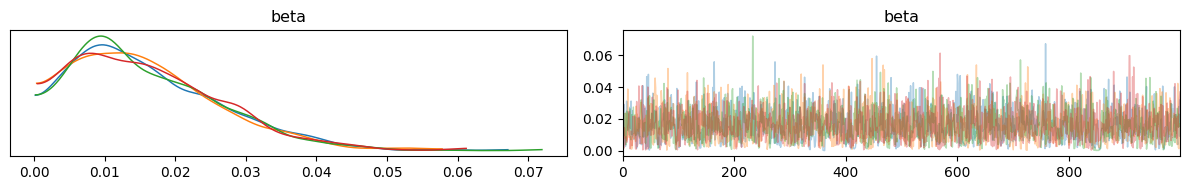

In [23]:
az.plot_trace(cmdstanpy_data['posterior']['beta'], compact=False)
plt.tight_layout()
plt.show()

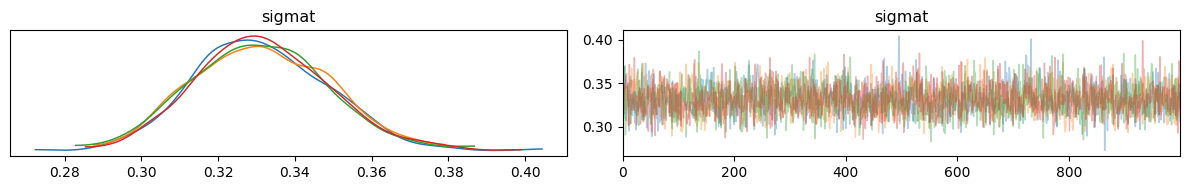

In [24]:
az.plot_trace(cmdstanpy_data['posterior']['sigmat'], compact=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (287), generating only 20 plots
  warnings.warn(


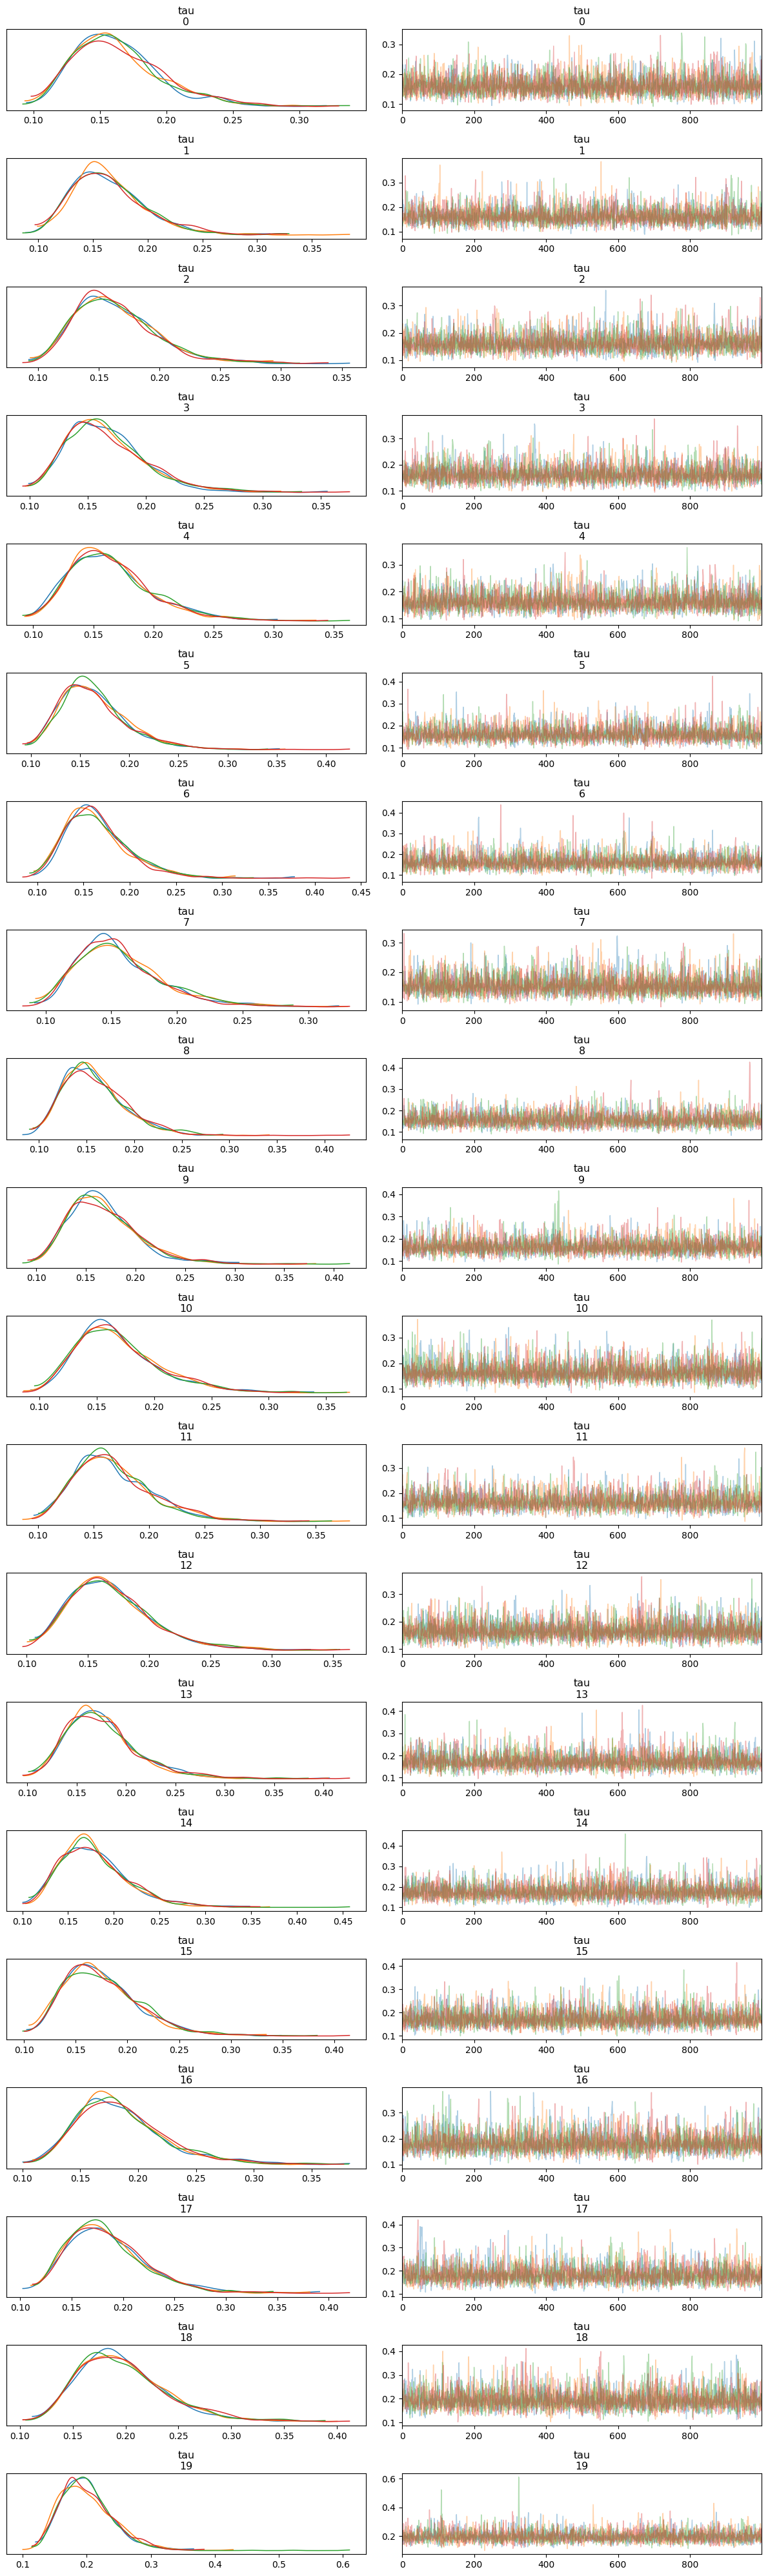

In [25]:
az.plot_trace(cmdstanpy_data['posterior']['tau'], compact=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (287), generating only 20 plots
  warnings.warn(


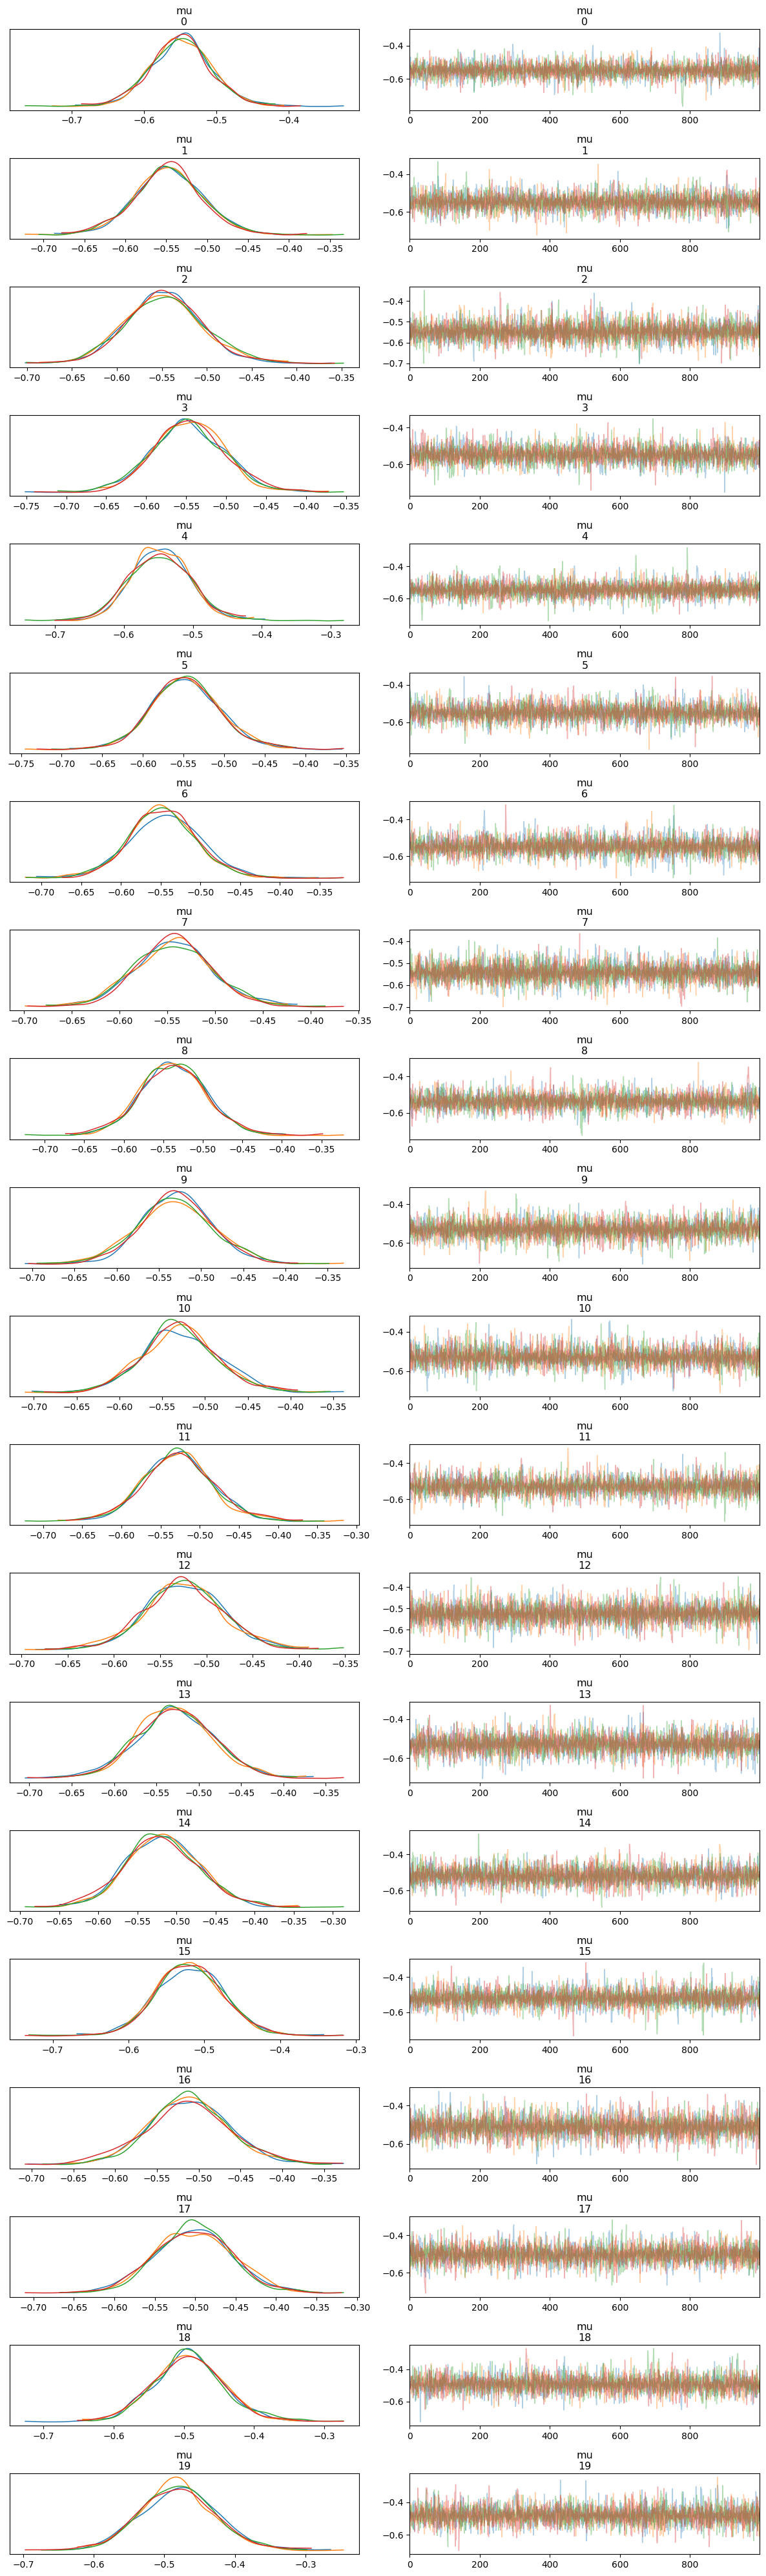

In [26]:
az.plot_trace(cmdstanpy_data['posterior']['mu'], compact=False)
plt.tight_layout()
plt.show()

In [27]:
betas = cmdstanpy_data['posterior']['beta'][3]
taus = cmdstanpy_data['posterior']['tau'][3]
mus = cmdstanpy_data['posterior']['mu'][3]
#sigmas = cmdstanpy_data['posterior']['sigma'][3]
beta = betas.mean().item() # convert to float
tau = taus.mean().item() # convert to float
mu = mus.mean().item() # convert to float
#sigma = sigmas.mean().item() # convert to float

In [28]:
mu = np.mean(mus, axis=0)

In [29]:
mu

<xarray.DataArray 'mu' (mu_dim_0: 287)> Size: 2kB
array([-5.50673574e-01, -5.48363043e-01, -5.46245712e-01, -5.43907779e-01,
       -5.47964960e-01, -5.46381891e-01, -5.44633647e-01, -5.43058162e-01,
       -5.36629412e-01, -5.28632719e-01, -5.28928607e-01, -5.26283993e-01,
       -5.25718449e-01, -5.26913092e-01, -5.20139587e-01, -5.18398659e-01,
       -5.12955695e-01, -5.03469072e-01, -4.94277083e-01, -4.81895278e-01,
       -4.70411678e-01, -4.19588078e-01, -3.93100641e-01, -3.96484946e-01,
       -4.09283553e-01, -4.23766940e-01, -4.40377931e-01, -4.65500319e-01,
       -4.60098760e-01, -4.30903108e-01, -4.17651290e-01, -4.21102697e-01,
       -4.22164558e-01, -4.39813300e-01, -4.75223111e-01, -4.93372479e-01,
       -4.85357057e-01, -4.71700245e-01, -4.68314356e-01, -4.78843752e-01,
       -4.74598185e-01, -4.86356317e-01, -4.83372599e-01, -4.97761719e-01,
       -5.04293969e-01, -4.99525989e-01, -4.86119978e-01, -4.81947900e-01,
       -4.41996704e-01, -4.30205457e-01, -4.12599546e-01, -4.25242209e-01,
       -4.44347530e-01, -4.36303726e-01, -4.81828417e-01, -4.08301387e-01,
       -3.90656999e-01, -3.90414396e-01, -3.36009796e-01, -3.43508970e-01,
       -3.67855978e-01, -4.58913196e-01, -4.84589356e-01, -4.48688092e-01,
       -4.82567947e-01, -4.62328111e-01, -3.31558822e-01, -2.50080690e-01,
       -2.16356983e-01, -1.74911328e-01, -1.53629481e-01, -1.61982129e-01,
       -2.25441553e-01, -2.19863608e-01, -1.54069922e-01, -1.85380556e-01,
       -1.66648591e-01, -1.18210612e-01, -6.00772605e-02,  6.62706507e-04,
...
       -2.90806837e-01, -9.06421302e-02,  1.33003067e-02,  5.86549379e-02,
        6.98788033e-02,  4.07260822e-02,  1.36028744e-01,  7.65327650e-02,
        8.35807638e-02,  8.75973110e-02,  2.24469849e-02,  1.51007361e-01,
        1.75612418e-01,  2.52648095e-01,  2.32837699e-01,  2.79787378e-01,
        2.73432857e-01,  2.20003476e-01,  1.55508158e-01,  5.46453922e-02,
        8.50078720e-02,  9.99343573e-02,  2.02896153e-01,  2.49075514e-01,
        2.10690838e-01,  2.69743490e-01,  2.91836104e-01,  2.96506250e-01,
        3.01022033e-01,  3.12266610e-01,  3.26318581e-01,  3.17360002e-01,
        1.69309271e-01,  2.94181788e-02, -3.04483534e-02, -8.28092174e-02,
        4.53661560e-02,  6.69687438e-02,  1.67937593e-01,  1.73643925e-01,
        1.80569672e-01,  1.84852672e-01,  1.17630955e-01,  1.40404999e-02,
       -2.90814312e-02, -4.04302561e-02, -1.19600488e-01, -1.05523072e-01,
       -6.93405672e-02,  1.23980853e-01,  9.30205803e-02,  1.84478312e-01,
        1.83280994e-01,  1.44225641e-01,  1.57852154e-01,  1.54050983e-02,
       -9.88063722e-03, -1.45519380e-01, -1.64026304e-01, -2.79174515e-01,
       -2.50495902e-01, -2.15504264e-01, -1.98880277e-01, -1.53907798e-01,
       -2.17417862e-01, -2.45232641e-01, -2.29972580e-01, -2.68501548e-01,
       -3.01624247e-01, -3.76349810e-01, -3.32496891e-01, -2.90462355e-01,
       -2.26750804e-01, -2.20016217e-01, -2.33232535e-01, -2.63706928e-01,
       -3.00031891e-01, -3.28518260e-01, -4.26448392e-01])
Coordinates:
    chain     int64 8B 3
  * mu_dim_0  (mu_dim_0) int64 2kB 0 1 2 3 4 5 6 ... 280 281 282 283 284 285 286

In [30]:
y_sim = beta*y[12,:] + (1-beta)*mu

In [31]:
tau = np.mean(taus, axis=0)
K = np.diag(tau)

In [32]:
y_draws = np.random.multivariate_normal(y_sim, K, 500)

In [33]:
y_new = np.mean(y_draws, axis=0)

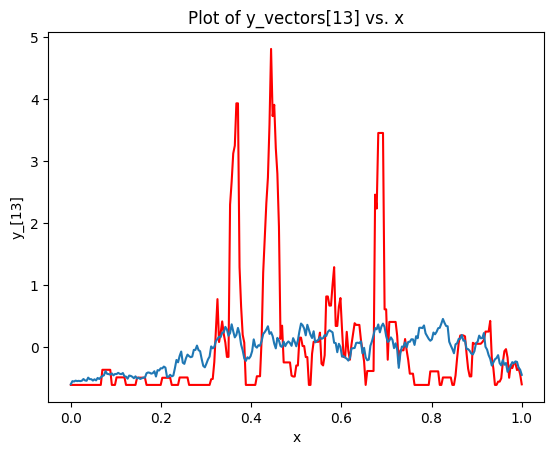

In [34]:
plt.plot(x, y[13,:], color="red")
plt.plot(x, y_new)
plt.xlabel("x")
plt.ylabel("y_[13]")
plt.title("Plot of y_vectors[13] vs. x")
plt.show()

Note: [extension to glm gaussian process](https://mc-stan.org/docs/stan-users-guide/gaussian-processes.html#discrete-outcomes-with-gaussian-processes) (not used in the project but interesting comunque)

Note for the future: [here to make predictions](https://mc-stan.org/docs/stan-users-guide/gaussian-processes.html#discrete-outcomes-with-gaussian-processes)